In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
Image_info_df = pd.read_csv('../Data/Gaussian_Retina_Data/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


Image_info_df['binary_type'] =  Image_info_df['diagnosis'].map(diagnosis_dict_binary.get)
Image_info_df['type'] = Image_info_df['diagnosis'].map(diagnosis_dict.get)
Image_info_df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


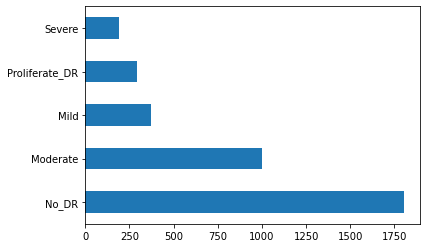

In [3]:
# Show how many of each type of retinopathy
Image_info_df['type'].value_counts().plot(kind='barh')

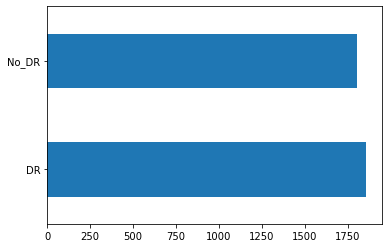

In [4]:
# Show the balance between no retinopathy and stages of retinopathy
Image_info_df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into train, and test sets
train, test = train_test_split(Image_info_df, test_size = 0.20)

# Show how many in each set
print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')

No_DR             1456
Moderate           794
Mild               282
Proliferate_DR     241
Severe             156
Name: type, dtype: int64 

No_DR             349
Moderate          205
Mild               88
Proliferate_DR     54
Severe             37
Name: type, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [7]:
# Copy images to respective working directory
src_dir = '../Data/Gaussian_Retina_Data/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.


# 8 Layer CNN Model

In [9]:
# Building the model

model = models.Sequential([
    layers.Conv2D(16, (3, 3), padding="same", activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')

])

# Show the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9

In [10]:
#######################################################################################
### I T E R A T I O N 1 ###############################################################
#######################################################################################


In [10]:
# Compile and Execute the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history_40_1 = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches)

Epoch 1/10
92/92 [==============================] - 126s 1s/step - loss: 0.7154 - acc: 0.3308 - val_loss: 0.6943 - val_acc: 0.0737
Epoch 2/10
92/92 [==============================] - 119s 1s/step - loss: 0.6496 - acc: 0.4333 - val_loss: 0.7059 - val_acc: 0.0737
Epoch 3/10
92/92 [==============================] - 118s 1s/step - loss: 0.6096 - acc: 0.4906 - val_loss: 0.7261 - val_acc: 0.0737
Epoch 4/10
92/92 [==============================] - 117s 1s/step - loss: 0.5826 - acc: 0.5179 - val_loss: 0.7583 - val_acc: 0.0737
Epoch 5/10
92/92 [==============================] - 109s 1s/step - loss: 0.5652 - acc: 0.5347 - val_loss: 0.7355 - val_acc: 0.0737
Epoch 6/10
92/92 [==============================] - 102s 1s/step - loss: 0.5473 - acc: 0.5398 - val_loss: 0.6700 - val_acc: 0.1473
Epoch 7/10
92/92 [==============================] - 104s 1s/step - loss: 0.5337 - acc: 0.5582 - val_loss: 0.5877 - val_acc: 0.4270
Epoch 8/10
92/92 [==============================] - 101s 1s/step - loss: 0.5239 - a

In [11]:
# Show the final accuracy of the model
acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc[1])

23/23 [==============================] - 7s 308ms/step - loss: 0.4913 - acc: 0.6044
Accuracy:  0.6043656468391418


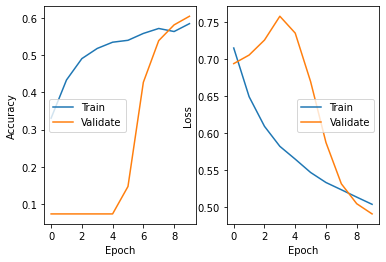

In [12]:
# plot the graphs of how the solution converges: Accuracy and Loss for the training and test data

plt.subplot(1,2,1)
plt.plot(history_40_1.history['acc'])
plt.plot(history_40_1.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center left')

plt.subplot(1,2,2)
plt.plot(history_40_1.history['loss'])
plt.plot(history_40_1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center right')


In [13]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['Moderate', 'Mild', 'Proliferate_DR', 'Proliferate_DR', 'Moderate', 'Mild', 'Mild', 'Proliferate_DR', 'Moderate', 'Moderate']


In [14]:
# Save the model
model.save("40-1_Retinopathy_model_trained.h5")

In [15]:
# Save the History
df=pd.DataFrame.from_dict(history_40_1.history, orient="index")
df.to_csv("40-1_history_data.csv")

In [16]:
# Save the predictions
import csv
with open("40-1_pred.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(pred)

In [17]:
#######################################################################################
### I T E R A T I O N 2 ###############################################################
#######################################################################################


In [17]:
# Compile and Execute the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history_40_2 = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches)

Epoch 1/10
92/92 [==============================] - 98s 1s/step - loss: 0.4974 - acc: 0.5825 - val_loss: 0.4844 - val_acc: 0.6166
Epoch 2/10
92/92 [==============================] - 95s 1s/step - loss: 0.4941 - acc: 0.5937 - val_loss: 0.4760 - val_acc: 0.6235
Epoch 3/10
92/92 [==============================] - 96s 1s/step - loss: 0.4820 - acc: 0.6005 - val_loss: 0.4660 - val_acc: 0.6330
Epoch 4/10
92/92 [==============================] - 96s 1s/step - loss: 0.4784 - acc: 0.6111 - val_loss: 0.4626 - val_acc: 0.6439
Epoch 5/10
92/92 [==============================] - 97s 1s/step - loss: 0.4741 - acc: 0.6070 - val_loss: 0.4593 - val_acc: 0.6344
Epoch 6/10
92/92 [==============================] - 96s 1s/step - loss: 0.4655 - acc: 0.6244 - val_loss: 0.4557 - val_acc: 0.6535
Epoch 7/10
92/92 [==============================] - 95s 1s/step - loss: 0.4610 - acc: 0.6350 - val_loss: 0.4505 - val_acc: 0.6426
Epoch 8/10
92/92 [==============================] - 95s 1s/step - loss: 0.4596 - acc: 0.62

In [18]:
# Show the final accuracy of the model
acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc[1])

23/23 [==============================] - 8s 331ms/step - loss: 0.4438 - acc: 0.6630
Accuracy:  0.6630286574363708


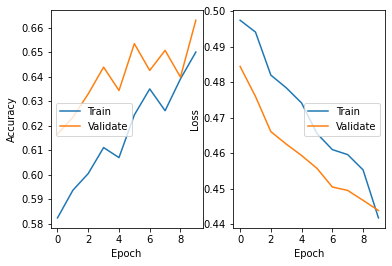

In [19]:
# plot the graphs of how the solution converges: Accuracy and Loss for the training and test data

plt.subplot(1,2,1)
plt.plot(history_40_2.history['acc'])
plt.plot(history_40_2.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center left')

plt.subplot(1,2,2)
plt.plot(history_40_2.history['loss'])
plt.plot(history_40_2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center right')

In [20]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['Moderate', 'Mild', 'Proliferate_DR', 'Mild', 'Mild', 'Mild', 'Mild', 'Proliferate_DR', 'Moderate', 'Proliferate_DR']


In [23]:
# Save the model
model.save("40-2_Retinopathy_model_trained.h5")
# Save the History
df=pd.DataFrame.from_dict(history_40_2.history, orient="index")
df.to_csv("40-2_history_data.csv")

In [22]:
# Save the predictions
import csv
with open("40-2_pred.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(pred)

In [22]:
#######################################################################################
### I T E R A T I O N 3 ###############################################################
#######################################################################################


In [24]:
# Compile and Execute the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history_40_3 = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches)
# Show the final accuracy of the model
acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc[1])

Epoch 1/10
92/92 [==============================] - 104s 1s/step - loss: 0.4416 - acc: 0.6494 - val_loss: 0.4419 - val_acc: 0.6439
Epoch 2/10
92/92 [==============================] - 110s 1s/step - loss: 0.4427 - acc: 0.6487 - val_loss: 0.4392 - val_acc: 0.6453
Epoch 3/10
92/92 [==============================] - 120s 1s/step - loss: 0.4342 - acc: 0.6647 - val_loss: 0.4355 - val_acc: 0.6576
Epoch 4/10
92/92 [==============================] - 121s 1s/step - loss: 0.4275 - acc: 0.6647 - val_loss: 0.4303 - val_acc: 0.6617
Epoch 5/10
92/92 [==============================] - 117s 1s/step - loss: 0.4272 - acc: 0.6719 - val_loss: 0.4323 - val_acc: 0.6671
Epoch 6/10
92/92 [==============================] - 105s 1s/step - loss: 0.4214 - acc: 0.6678 - val_loss: 0.4359 - val_acc: 0.6521
Epoch 7/10
92/92 [==============================] - 105s 1s/step - loss: 0.4206 - acc: 0.6753 - val_loss: 0.4288 - val_acc: 0.6589
Epoch 8/10
92/92 [==============================] - 104s 1s/step - loss: 0.4152 - a

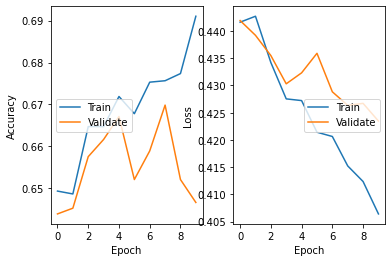

In [25]:
# plot the graphs of how the solution converges: Accuracy and Loss for the training and test data

plt.subplot(1,2,1)
plt.plot(history_40_3.history['acc'])
plt.plot(history_40_3.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center left')

plt.subplot(1,2,2)
plt.plot(history_40_3.history['loss'])
plt.plot(history_40_3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center right')

In [26]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['Moderate', 'Mild', 'Moderate', 'Mild', 'Moderate', 'Mild', 'Mild', 'No_DR', 'Moderate', 'Proliferate_DR']


In [27]:
# Save the model
model.save("40-3_Retinopathy_model_trained.h5")
# Save the History
df=pd.DataFrame.from_dict(history_40_3.history, orient="index")
df.to_csv("40-3_history_data.csv")

In [28]:
#######################################################################################
### I T E R A T I O N 4 ###############################################################
#######################################################################################


In [29]:
# Compile and Execute the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history_40_4 = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches)
# Show the final accuracy of the model
acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc[1])

Epoch 1/10
92/92 [==============================] - 116s 1s/step - loss: 0.4002 - acc: 0.6876 - val_loss: 0.4235 - val_acc: 0.6562
Epoch 2/10
92/92 [==============================] - 128s 1s/step - loss: 0.3999 - acc: 0.6951 - val_loss: 0.4192 - val_acc: 0.6412
Epoch 3/10
92/92 [==============================] - 121s 1s/step - loss: 0.3867 - acc: 0.7159 - val_loss: 0.4163 - val_acc: 0.6521
Epoch 4/10
92/92 [==============================] - 110s 1s/step - loss: 0.3936 - acc: 0.7040 - val_loss: 0.4185 - val_acc: 0.6589
Epoch 5/10
92/92 [==============================] - 110s 1s/step - loss: 0.3935 - acc: 0.7013 - val_loss: 0.4152 - val_acc: 0.6371
Epoch 6/10
92/92 [==============================] - 108s 1s/step - loss: 0.3850 - acc: 0.7019 - val_loss: 0.4174 - val_acc: 0.6494
Epoch 7/10
92/92 [==============================] - 110s 1s/step - loss: 0.3863 - acc: 0.7037 - val_loss: 0.4128 - val_acc: 0.6521
Epoch 8/10
92/92 [==============================] - 111s 1s/step - loss: 0.3768 - a

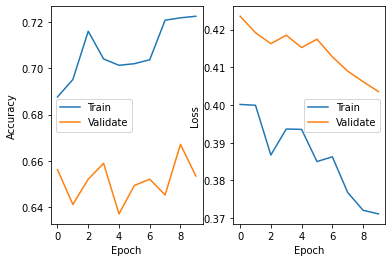

In [30]:
# plot the graphs of how the solution converges: Accuracy and Loss for the training and test data

plt.subplot(1,2,1)
plt.plot(history_40_4.history['acc'])
plt.plot(history_40_4.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center left')

plt.subplot(1,2,2)
plt.plot(history_40_4.history['loss'])
plt.plot(history_40_4.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center right')

In [31]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['Moderate', 'Mild', 'Moderate', 'Mild', 'Moderate', 'Mild', 'Mild', 'Mild', 'Moderate', 'Proliferate_DR']


In [33]:
# Save the model
model.save("40-4_Retinopathy_model_trained.h5")
# Save the History
df=pd.DataFrame.from_dict(history_40_4.history, orient="index")
df.to_csv("40-4_history_data.csv")
# Save the predictions
import csv
with open("40-4_pred.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(pred)

In [34]:
#######################################################################################
### I T E R A T I O N 5 ###############################################################
#######################################################################################

In [35]:
# Compile and Execute the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history_40_5 = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches)
# Show the final accuracy of the model
acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc[1])

Epoch 1/10
92/92 [==============================] - 107s 1s/step - loss: 0.3703 - acc: 0.7228 - val_loss: 0.4046 - val_acc: 0.6535
Epoch 2/10
92/92 [==============================] - 104s 1s/step - loss: 0.3630 - acc: 0.7194 - val_loss: 0.4064 - val_acc: 0.6589
Epoch 3/10
92/92 [==============================] - 105s 1s/step - loss: 0.3645 - acc: 0.7296 - val_loss: 0.4043 - val_acc: 0.6508
Epoch 4/10
92/92 [==============================] - 103s 1s/step - loss: 0.3510 - acc: 0.7487 - val_loss: 0.4052 - val_acc: 0.6453
Epoch 5/10
92/92 [==============================] - 109s 1s/step - loss: 0.3485 - acc: 0.7460 - val_loss: 0.4007 - val_acc: 0.6576
Epoch 6/10
92/92 [==============================] - 103s 1s/step - loss: 0.3572 - acc: 0.7293 - val_loss: 0.3984 - val_acc: 0.6535
Epoch 7/10
92/92 [==============================] - 99s 1s/step - loss: 0.3563 - acc: 0.7286 - val_loss: 0.3974 - val_acc: 0.6658
Epoch 8/10
92/92 [==============================] - 104s 1s/step - loss: 0.3564 - ac

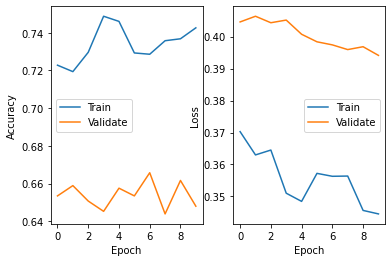

In [36]:
# plot the graphs of how the solution converges: Accuracy and Loss for the training and test data

plt.subplot(1,2,1)
plt.plot(history_40_5.history['acc'])
plt.plot(history_40_5.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center left')

plt.subplot(1,2,2)
plt.plot(history_40_5.history['loss'])
plt.plot(history_40_5.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center right')

In [37]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['Moderate', 'Mild', 'Moderate', 'Proliferate_DR', 'Moderate', 'Mild', 'Mild', 'Mild', 'Moderate', 'Proliferate_DR']


In [38]:
# Save the model
model.save("40-5_Retinopathy_model_trained.h5")
# Save the History
df=pd.DataFrame.from_dict(history_40_5.history, orient="index")
df.to_csv("40-5_history_data.csv")
# Save the predictions
import csv
with open("40-5_pred.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(pred)

In [39]:
#######################################################################################
### I T E R A T I O N 6 ###############################################################
#######################################################################################


In [40]:
# Compile and Execute the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history_40_6 = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches)
# Show the final accuracy of the model
acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc[1])

Epoch 1/10
92/92 [==============================] - 104s 1s/step - loss: 0.3384 - acc: 0.7562 - val_loss: 0.3937 - val_acc: 0.6630
Epoch 2/10
92/92 [==============================] - 110s 1s/step - loss: 0.3453 - acc: 0.7446 - val_loss: 0.3912 - val_acc: 0.6603
Epoch 3/10
92/92 [==============================] - 106s 1s/step - loss: 0.3376 - acc: 0.7552 - val_loss: 0.3893 - val_acc: 0.6562
Epoch 4/10
92/92 [==============================] - 112s 1s/step - loss: 0.3383 - acc: 0.7446 - val_loss: 0.3874 - val_acc: 0.6671
Epoch 5/10
92/92 [==============================] - 104s 1s/step - loss: 0.3306 - acc: 0.7590 - val_loss: 0.3884 - val_acc: 0.6576
Epoch 6/10
92/92 [==============================] - 129s 1s/step - loss: 0.3315 - acc: 0.7603 - val_loss: 0.3905 - val_acc: 0.6535
Epoch 7/10
92/92 [==============================] - 122s 1s/step - loss: 0.3312 - acc: 0.7607 - val_loss: 0.3884 - val_acc: 0.6521
Epoch 8/10
92/92 [==============================] - 106s 1s/step - loss: 0.3249 - a

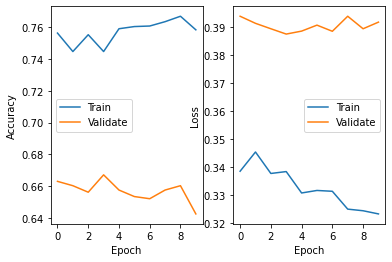

In [41]:
# plot the graphs of how the solution converges: Accuracy and Loss for the training and test data

plt.subplot(1,2,1)
plt.plot(history_40_6.history['acc'])
plt.plot(history_40_6.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center left')

plt.subplot(1,2,2)
plt.plot(history_40_6.history['loss'])
plt.plot(history_40_6.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='center right')

In [44]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['Moderate', 'Mild', 'Moderate', 'Proliferate_DR', 'Moderate', 'Mild', 'Mild', 'Mild', 'Moderate', 'Proliferate_DR']


In [45]:
# Save the model
model.save("40-6_Retinopathy_model_trained.h5")
# Save the History
df=pd.DataFrame.from_dict(history_40_6.history, orient="index")
df.to_csv("40-6_history_data.csv")
# Save the predictions
import csv
with open("40-6_pred.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(pred)